In [11]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, accuracy_score, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


In [15]:
def read_file_content(file_path):
    """
    Read and return the content of a file specified by its path.
    
    Args:
    file_path (str): The path to the file to be read.
    
    Returns:
    str: The content of the file.
    """
    with open(file_path, 'r') as file:
        content = file.read()
    return content

def extract_simulation_parameters(hsd_content):
    """
    Extract simulation parameters from the given HSD file content using regular expressions.
    
    Args:
    hsd_content (str): Content of the HSD file as a string.
    
    Returns:
    dict: A dictionary with parameter names as keys and extracted values as values. 
          Polarization directions are returned as tuples of floats.
    """
    patterns = {
        'LaserEnergy': r'LaserEnergy \[eV\] = (\d+\.\d+)',
        'PolarizationDirection': r'PolarizationDirection = (\d*\.?\d+) (\d*\.?\d+) (\d*\.?\d+)',
        'FieldStrength': r'FieldStrength \[V/A\] = (\d+\.\d+)',
        'InitialTemperature': r'InitialTemperature \[K\] = (\d+\.\d+)',
        'Steps': r'Steps = (\d+)',
        'ImagPolarizationDirection': r'ImagPolarizationDirection = (\d*\.?\d+) (\d*\.?\d+) (\d*\.?\d+)'
    }

    extracted_params = {}
    for param, pattern in patterns.items():
        match = re.search(pattern, hsd_content)
        if match:
            # Handle extraction of vector values for directions as tuples of floats
            if param in ['PolarizationDirection', 'ImagPolarizationDirection']:
                extracted_params[param] = tuple(map(float, match.groups()))
            else:
                # Convert to appropriate numerical type based on presence of decimal point
                value = match.group(1)
                extracted_params[param] = float(value) if '.' in value else int(value)

    return extracted_params


In [19]:
import numpy as np

def calculate_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points represented as tuples or lists.
    
    Args:
    coord1 (list or tuple): Coordinates of the first point.
    coord2 (list or tuple): Coordinates of the second point.
    
    Returns:
    float: The Euclidean distance between the two points.
    """
    return np.sqrt(np.sum((np.array(coord1) - np.array(coord2)) ** 2))

def parse_xyz_and_calculate_distances(file_path):
    """
    Parse an XYZ file to extract coordinates of hydrogen atoms and calculate distances between them.
    
    Args:
    file_path (str): Path to the XYZ file.
    
    Returns:
    list: Distances between each pair of hydrogen atoms found in the file.
    """
    distances = []
    with open(file_path, 'r') as file:
        while True:
            line = file.readline()
            if not line:
                break  # End of file
            try:
                num_atoms = int(line.strip())
            except ValueError:
                continue  # Skip lines that cannot be converted to an integer
            file.readline()  # Skip the comment line
            hydrogen_coords = []
            for _ in range(num_atoms):
                line = file.readline().strip().split()
                atom_type = line[0]
                try:
                    coords = list(map(float, line[1:4]))
                except ValueError:
                    continue  # Skip lines with invalid float conversion
                if atom_type == 'H':
                    hydrogen_coords.append(coords)
            if len(hydrogen_coords) == 2:
                distance = calculate_distance(hydrogen_coords[0], hydrogen_coords[1])
                distances.append(distance)
    return distances

# Function to analyze and report statistics on the last valid distances
def analyze_last_valid_distances(distances, count=1000):
    """
    Analyze the last up to 'count' valid (non-NaN) distances and calculate the mean.
    
    Args:
    distances (list): List of distances to analyze.
    count (int): Maximum number of valid distances to consider.
    
    Returns:
    None: Prints the mean of the valid distances or a message if no valid distances were found.
    """
    last_valid_distances = [d for d in reversed(distances) if not np.isnan(d)]
    if len(last_valid_distances) > 0:
        last_valid_distances = last_valid_distances[:count]
        last_valid_distances_mean = np.nanmean(last_valid_distances)
        print("Mean of the last valid (non-NaN) distances:", last_valid_distances_mean)
    else:
        print("No valid (non-NaN) distances were found in the file.")

# Example usage
# file_path = '/Users/ayushsharma/Documents/Spring 2024/Lab Research/training_run_23/tdcoords.xyz'
# distances = parse_xyz_and_calculate_distances(file_path)
# analyze_last_valid_distances(distances)


In [23]:
threshold_distance = 2  # Set threshold distance to define conditions for dissociation

def prepare_simulation_data(base_path, num_simulations=200):
    """
    Prepare the dataset by processing simulation files.
    
    Args:
    base_path (str): Base path to the directory containing simulation data.
    num_simulations (int): Number of simulations to process.
    
    Returns:
    pd.DataFrame: DataFrame containing features and labels from the simulations.
    """
    data = []
    for simulation in range(1, num_simulations):
        # Construct file paths for input and output files
        input_file_path = f"{base_path}/training_run_{simulation}/dftb_in.hsd"
        output_file_path = f"{base_path}/training_run_{simulation}/tdcoords.xyz"

        # Extract features from HSD content
        hsd_content = read_file_content(input_file_path)
        features = extract_simulation_parameters(hsd_content)

        # Extract distances and compute final distance mean
        distances = parse_xyz_and_calculate_distances(output_file_path)
        last_valid_distances_list = [d for d in reversed(distances) if not np.isnan(d)][:1000]
        
        if last_valid_distances_list:
            features['FinalDistance'] = np.nanmean(last_valid_distances_list)
        else:
            features['FinalDistance'] = None  # Handle case with no valid distances

        # Determine if the final distance exceeds the threshold, implying dissociation
        dissociation = features['FinalDistance'] > threshold_distance if features['FinalDistance'] is not None else None
        if dissociation is not None:
            features['Dissociation'] = dissociation
            features['Run'] = f"run_{simulation}"
            data.append(features)

    # Create a DataFrame from the compiled data
    return pd.DataFrame(data)



# PLEASE CHANGE THIS BASED ON YOUR DIRECTORY STRUCTURE ------------------------------------------------------------
base_path = "./simulations_data"
# PLEASE CHANGE THIS BASED ON YOUR DIRECTORY STRUCTURE ------------------------------------------------------------


# Prepare the data
df = prepare_simulation_data(base_path)
print(df)


     LaserEnergy PolarizationDirection  FieldStrength  InitialTemperature  \
0       5.637807   (0.707, 0.0, 0.707)       1.634787          965.778452   
1       5.206872       (0.0, 1.0, 0.0)       2.259675          333.029617   
2       2.812482   (0.0, 0.707, 0.707)       3.131774           44.295232   
3       5.027333       (0.0, 1.0, 0.0)       3.189229          645.082670   
4       9.042085   (0.707, 0.707, 0.0)       0.479359          257.671135   
..           ...                   ...            ...                 ...   
194    12.443380   (0.707, 0.707, 0.0)       2.287861          753.078831   
195    10.545715       (0.0, 1.0, 0.0)       1.743251          870.625337   
196     9.390290   (0.707, 0.707, 0.0)       1.403224          484.362157   
197     8.974561       (0.0, 1.0, 0.0)       0.479282          940.142049   
198     7.087345   (0.707, 0.707, 0.0)       1.270215          514.743287   

     Steps ImagPolarizationDirection  FinalDistance  Dissociation      Run 

In [9]:
# Execute the DFTB+ simulation within the 'Phase3/training_run_199' directory and redirect the output to 'output.txt'
!(cd Phase3/training_run_199 && dftb+ | tee output.txt)

zsh:cd:1: no such file or directory: Phase3/training_run_199


In [24]:
# Define a mapping from polarization direction tuples to categorical integers
polarization_mapping = {
    ("1 0 0", "0 0 0"): 0,
    ("0 0 1", "0 0 0"): 1,
    ("0 1 0", "0 0 0"): 2,
    ("0.707 0.707 0", "0 0 0"): 3,
    ("0.707 0 0.707", "0 0 0"): 4,
    ("0.707 0 0", "0 0 0.707"): 5,
    ("0 0.707 0.707", "0 0 0.707"): 6,
    ("0.707 0.707 0", "0 0 0.5"): 7
}

def format_float(f):
    """
    Format a floating-point number to a string with up to three decimal places,
    removing unnecessary trailing zeros and decimal points.
    
    Args:
    f (float): The floating-point number to format.
    
    Returns:
    str: The formatted string representation of the number.
    """
    if int(f) == f:
        return str(int(f))  # Convert whole numbers directly to integer strings
    else:
        formatted_float = "{:.3f}".format(f).rstrip('0').rstrip('.')
        return formatted_float if formatted_float else "0"

def map_polarization(row):
    """
    Map the polarization direction from DataFrame row to a categorical integer using a predefined mapping.
    
    Args:
    row (pd.Series): A DataFrame row containing 'PolarizationDirection' and 'ImagPolarizationDirection'.
    
    Returns:
    int: The mapped category integer; returns -1 if no mapping is found.
    """
    polarization_str = ' '.join(format_float(x) for x in row['PolarizationDirection'])
    imag_polarization_str = ' '.join(format_float(x) for x in row['ImagPolarizationDirection'])
    polarization_tuple = (polarization_str, imag_polarization_str)
    
    return polarization_mapping.get(polarization_tuple, -1)

# Apply the mapping function to the DataFrame
df['PolarizationCategory'] = df.apply(map_polarization, axis=1)

# Output the count of each category
print(df['PolarizationCategory'].value_counts())

# If you need a copy of the DataFrame for further processing
df2 = df.copy()  # Make a copy of df to df2 for further modifications or analysis

PolarizationCategory
1    39
7    28
4    26
2    26
6    23
5    22
3    19
0    16
Name: count, dtype: int64


In [25]:
# Assuming 'df' is your DataFrame
print("DataFrame Info:")
df.info()  # Provides column names, non-null counts, and dtypes


print("\nFirst 5 Rows:")
print(df.head())  # Displays the first 5 rows for a quick data preview

print("\nData Types:")
print(df.dtypes)  # Lists the data type of each column

print("\nStatistics Summary:")
print(df.describe())  # Shows a statistical summary for numeric columns


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LaserEnergy                199 non-null    float64
 1   PolarizationDirection      199 non-null    object 
 2   FieldStrength              199 non-null    float64
 3   InitialTemperature         199 non-null    float64
 4   Steps                      199 non-null    int64  
 5   ImagPolarizationDirection  199 non-null    object 
 6   FinalDistance              199 non-null    float64
 7   Dissociation               199 non-null    bool   
 8   Run                        199 non-null    object 
 9   PolarizationCategory       199 non-null    int64  
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 14.3+ KB

First 5 Rows:
   LaserEnergy PolarizationDirection  FieldStrength  InitialTemperature  \
0     5.637807   (0.707, 0.0, 0.707)       1.

In [35]:
# Prepare features and target variables from DataFrame
X = df.drop(['PolarizationDirection', 'ImagPolarizationDirection', 'Dissociation', 'Run', 'FinalDistance'], axis=1)
y = df['Dissociation']

# Extract and transform continuous features using Polynomial Features
continuous_features = X[['LaserEnergy', 'FieldStrength', 'InitialTemperature']]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(continuous_features)

# Generate feature names for polynomial features
try:
    poly_feature_names = poly.get_feature_names_out(continuous_features.columns)
except AttributeError:  # Fallback for older versions of scikit-learn
    poly_feature_names = poly.get_feature_names(continuous_features.columns)
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Apply One-Hot Encoding to the 'PolarizationCategory'
onehot_encoder = OneHotEncoder(sparse_output=False)
polarization_category_encoded = onehot_encoder.fit_transform(X[['PolarizationCategory']])
category_cols = [f"PolarizationCategory_{int(i)}" for i in range(polarization_category_encoded.shape[1])]
polarization_category_encoded_df = pd.DataFrame(polarization_category_encoded, columns=category_cols)

# Create interaction term directly within the DataFrame
X['Energy_Field_Interaction'] = X['LaserEnergy'] * X['FieldStrength']

# Concatenate all engineered features to form the final features DataFrame
X_engineered = pd.concat([
    X.drop(['PolarizationCategory'], axis=1),
    poly_features_df,
    polarization_category_encoded_df
], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.3, random_state=42)

# Initialize and train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Extract feature importances and create a DataFrame for display
feature_importances = clf.feature_importances_
features_df = pd.DataFrame({'Feature': X_engineered.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(features_df)

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00        51
        True       1.00      1.00      1.00         9

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

                             Feature  Importance
0                        LaserEnergy    0.154258
10         LaserEnergy FieldStrength    0.149659
4                      LaserEnergy^2    0.138538
5           Energy_Field_Interaction    0.115787
6                        LaserEnergy    0.104096
9                      LaserEnergy^2    0.096136
12                   FieldStrength^2    0.052017
11    LaserEnergy InitialTemperature    0.041266
1                      FieldStrength    0.035812
7                      FieldStrength    0.028765
13  FieldStrength InitialTemperature    0.025895
8                 InitialTemperature    0.0169

In [37]:
# Increase the degree of polynomial features for more complex interactions
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(continuous_features)

# Generate feature names, with compatibility for different versions of scikit-learn
try:
    poly_feature_names = poly.get_feature_names_out(input_features=continuous_features.columns)
except AttributeError:
    poly_feature_names = poly.get_feature_names(input_features=continuous_features.columns)

# Create a DataFrame for polynomial features
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Apply One-Hot Encoding to the 'PolarizationCategory'
onehot_encoder = OneHotEncoder(sparse_output=False)
polarization_category_encoded = onehot_encoder.fit_transform(X[['PolarizationCategory']])
category_cols = [f"PolarizationCategory_{int(i)}" for i in range(polarization_category_encoded.shape[1])]
polarization_category_encoded_df = pd.DataFrame(polarization_category_encoded, columns=category_cols)

# Create interaction features between polynomial features and one-hot encoded categories
for col in poly_feature_names:
    for i in range(polarization_category_encoded_df.shape[1]):
        new_col_name = f'PolarizationCategory_{i}*{col}'
        X[new_col_name] = polarization_category_encoded_df[f'PolarizationCategory_{i}'] * poly_features_df[col]

# Concatenate all engineered features to form the final features DataFrame
X_engineered = pd.concat([X.drop(['PolarizationCategory'], axis=1), poly_features_df, polarization_category_encoded_df], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.3, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier's performance
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate and display feature importances
feature_importances = clf.feature_importances_
features_df = pd.DataFrame({'Feature': X_engineered.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Displaying non-zero feature importances for better insight
non_zero_features = features_df[features_df['Importance'] > 0]
print(non_zero_features)

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        51
        True       1.00      0.67      0.80         9

    accuracy                           0.95        60
   macro avg       0.97      0.83      0.89        60
weighted avg       0.95      0.95      0.95        60

                                               Feature  Importance
168                        LaserEnergy^2 FieldStrength    0.142668
167                                      LaserEnergy^3    0.080783
161                                      LaserEnergy^2    0.076069
162                          LaserEnergy FieldStrength    0.060963
169                   LaserEnergy^2 InitialTemperature    0.054821
158                                        LaserEnergy    0.050479
171       LaserEnergy FieldStrength InitialTemperature    0.047550
170                        LaserEnergy FieldStrength^2    0.043226
0                             

/var/folders/mq/tq214nm5353bf9rwyzv43lxr0000gn/T/ipykernel_82987/2957003669.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/mq/tq214nm5353bf9rwyzv43lxr0000gn/T/ipykernel_82987/2957003669.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/mq/tq214nm5353bf9rwyzv43lxr0000gn/T/ipykernel_82987/2957003669.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

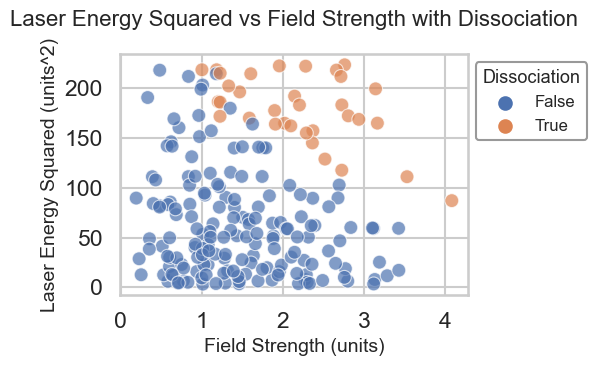

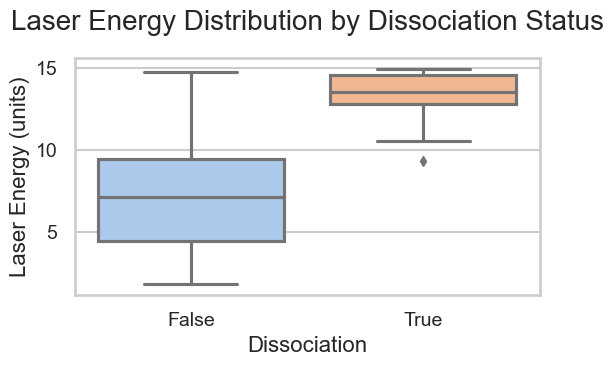

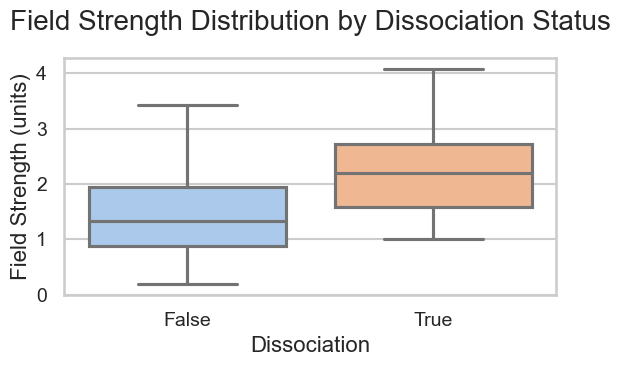

In [38]:
df['LaserEnergy^2'] = df['LaserEnergy'] ** 2

# Setting up the visual improvements
sns.set_theme(style="whitegrid")
sns.set_context("talk")

# Adjusting the figure size and placing the legend outside the plot
plt.figure(figsize=(8, 4))  # Adjusted figure size for better spacing
scatter_plot = sns.scatterplot(data=df, x='FieldStrength', y='LaserEnergy^2', hue='Dissociation', palette='deep', s=100, edgecolor='w', alpha=0.7)
scatter_plot.set_title('Laser Energy Squared vs Field Strength with Dissociation', fontsize=16, pad=20)
scatter_plot.set_xlabel('Field Strength (units)', fontsize=14)
scatter_plot.set_ylabel('Laser Energy Squared (units^2)', fontsize=14)
plt.legend(title='Dissociation', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, edgecolor='gray')
plt.tight_layout(rect=[0,0,0.75,1])  # Adjust layout to make space for legend
plt.show()

# Boxplot for LaserEnergy vs Dissociation with improved aesthetics
plt.figure(figsize=(6, 4))
box_plot_energy = sns.boxplot(data=df, x='Dissociation', y='LaserEnergy', palette='pastel')
box_plot_energy.set_title('Laser Energy Distribution by Dissociation Status', fontsize=20, pad=20)
box_plot_energy.set_xlabel('Dissociation', fontsize=16)
box_plot_energy.set_ylabel('Laser Energy (units)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot for FieldStrength vs Dissociation with improved aesthetics
plt.figure(figsize=(6, 4))
box_plot_field = sns.boxplot(data=df, x='Dissociation', y='FieldStrength', palette='pastel')
box_plot_field.set_title('Field Strength Distribution by Dissociation Status', fontsize=20, pad=20)
box_plot_field.set_xlabel('Dissociation', fontsize=16)
box_plot_field.set_ylabel('Field Strength (units)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


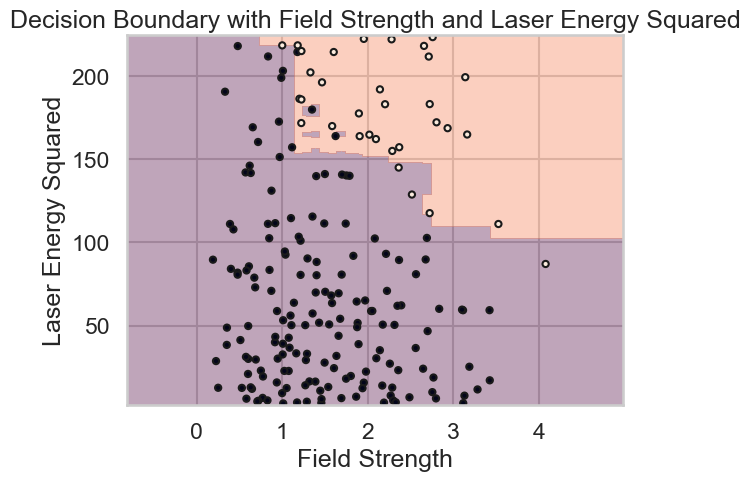

In [31]:
# Assuming 'FieldStrength' and 'LaserEnergySquared' are your features, and 'Dissociation' is your target.
X = df[['FieldStrength', 'LaserEnergy^2']]  # Make sure 'LaserEnergy^2' is correctly computed and included in your DataFrame
y = df['Dissociation']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


# Create a mesh grid
x_min, x_max = X['FieldStrength'].min() - 1, X['FieldStrength'].max() + 1
y_min, y_max = X['LaserEnergy^2'].min() - 1, X['LaserEnergy^2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict dissociation probabilities on the grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Generate the plot
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X['FieldStrength'], X['LaserEnergy^2'], c=y, s=20, edgecolor='k')
plt.title('Decision Boundary with Field Strength and Laser Energy Squared')
plt.xlabel('Field Strength')
plt.ylabel('Laser Energy Squared')
plt.show()


In [32]:


# Define your features and target variable
X = df[['FieldStrength', 'LaserEnergy^2']]
y = df['Dissociation']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline that creates polynomial features and then fits a linear regression model
degree = 2  # You can adjust the degree based on model performance and overfitting considerations
polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())

polyreg.fit(X_train, y_train)
from sklearn.metrics import r2_score

y_pred = polyreg.predict(X_test)
print(f"R-squared: {r2_score(y_test, y_pred)}")


# Extract coefficients and intercept
poly_features = polyreg.named_steps['polynomialfeatures']
lin_reg = polyreg.named_steps['linearregression']

coefficients = lin_reg.coef_
intercept = lin_reg.intercept_

# Print the polynomial equation
# Note: The actual construction of the equation depends on the degree and the number of features
print(f"Equation: y = {intercept} + {coefficients[1]}*X1 + {coefficients[2]}*X2 + ... + {coefficients[-1]}*Xn")


R-squared: 0.6957441225791161
Equation: y = 0.0882195904239747 + -0.08692221933803224*X1 + -0.003907277741164764*X2 + ... + 1.951972486667969e-05*Xn


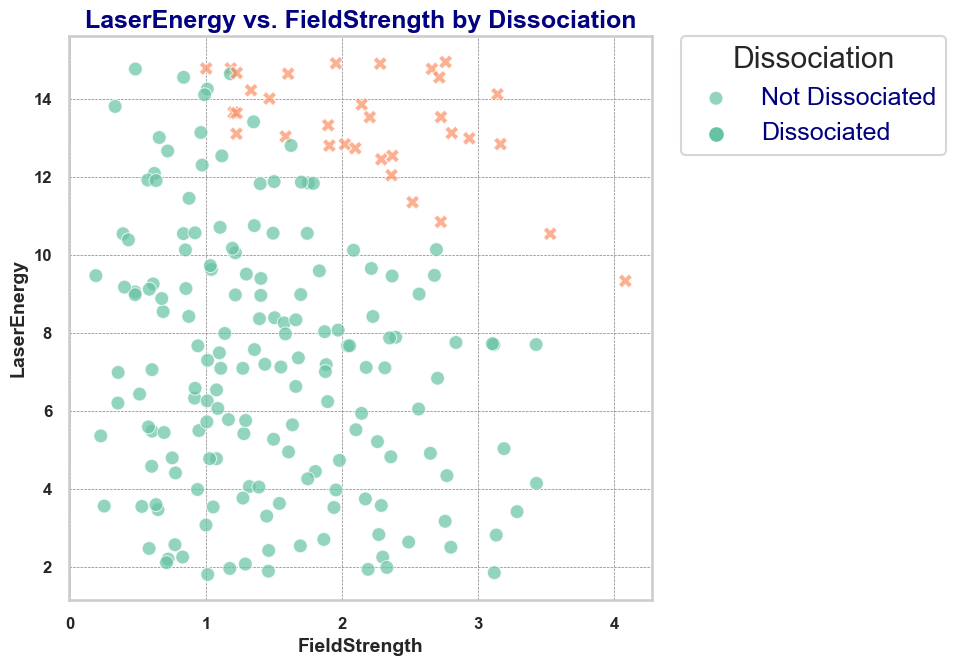

In [33]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='FieldStrength', y='LaserEnergy', hue='Dissociation', palette='Set2', style='Dissociation', s=100, alpha=0.7)
plt.title('LaserEnergy vs. FieldStrength by Dissociation', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('FieldStrength', fontsize=14, fontweight='bold')
plt.ylabel('LaserEnergy', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adjusting the legend to make it more appealing and less obstructive
leg = plt.legend(title='Dissociation', labels=['Not Dissociated', 'Dissociated'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='medium', title_fontsize='large')
for text in leg.get_texts():
    text.set_color("navy")

plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
plt.tight_layout()
plt.show()


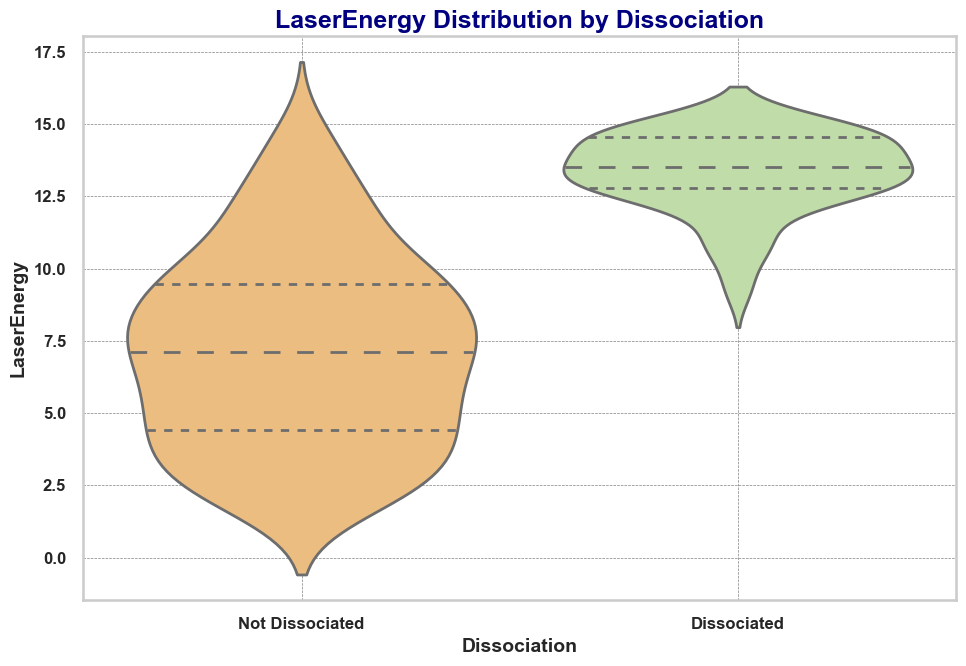

In [9]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='Dissociation', y='LaserEnergy', data=df, palette='Spectral', inner='quartile', scale='width', linewidth=2)
plt.title('LaserEnergy Distribution by Dissociation', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Dissociation', fontsize=14, fontweight='bold')
plt.ylabel('LaserEnergy', fontsize=14, fontweight='bold')

# Correctly setting custom labels for x-ticks
plt.xticks(ticks=[0, 1], labels=['Not Dissociated', 'Dissociated'], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
plt.tight_layout()
plt.show()


/var/folders/mq/tq214nm5353bf9rwyzv43lxr0000gn/T/ipykernel_12391/2251169889.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


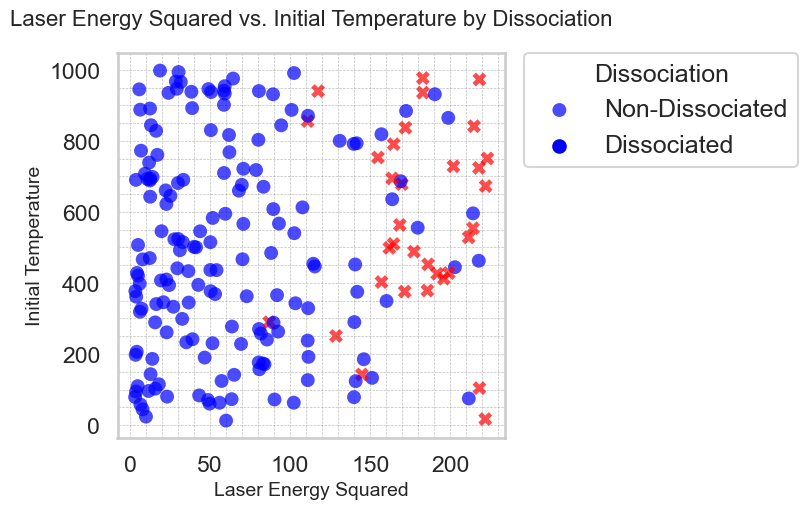

In [10]:
plt.figure(figsize=(5, 5))
palette = {False: 'blue', True: 'red'}

scatter = sns.scatterplot(data=df, x='LaserEnergy^2', y='InitialTemperature', hue='Dissociation', 
                          palette=palette, style='Dissociation', s=100, alpha=0.7, edgecolor='none')

plt.title('Laser Energy Squared vs. Initial Temperature by Dissociation', fontsize=16, pad=20)
plt.xlabel('Laser Energy Squared', fontsize=14)
plt.ylabel('Initial Temperature', fontsize=14)

# Enhancing the grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.minorticks_on()

# Shrink the legend size and move it outside the plot
plt.legend(title='Dissociation', labels=['Non-Dissociated', 'Dissociated'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='medium', title_fontsize='medium')

# Adjust plot to make space for the legend outside and ensure tight layout
plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.show()

In [34]:
import plotly.express as px

fig = px.scatter_3d(df, x='LaserEnergy', y='FieldStrength', z='InitialTemperature',
                    color='Dissociation', color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(title='3D Scatter Plot for LaserEnergy, FieldStrength, InitialTemperature by Dissociation')
fig.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the mapping from polarization category numbers to readable names
readable_polarization = {
    0: "x linearly polarized",
    1: "z linearly polarized",
    2: "y linearly polarized",
    3: "xy linearly polarized",
    4: "xz linearly polarized",
    5: "xy circularly polarized",
    6: "xz circularly polarized",
    7: "xy elliptically polarized"
}

# Calculate the count of dissociation being True for each PolarizationCategory.
dissociation_counts = df2[df2['Dissociation'] == True]['PolarizationCategory'].value_counts().sort_index()

# Map the indices to readable names
dissociation_counts.index = [readable_polarization[i] for i in dissociation_counts.index]

# Calculate the average Laser Energy and Field Strength for each PolarizationCategory.
avg_laser_energy = df2.groupby('PolarizationCategory')['LaserEnergy'].mean().sort_index()
avg_field_strength = df2.groupby('PolarizationCategory')['FieldStrength'].mean().sort_index()

# Map the indices to readable names
avg_laser_energy.index = [readable_polarization[i] for i in avg_laser_energy.index]
avg_field_strength.index = [readable_polarization[i] for i in avg_field_strength.index]

# Start plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for dissociation counts
dissociation_counts.plot(kind='bar', color='skyblue', ax=ax1, width=0.4, position=1, label='Dissociation Count')

# Create another axis for the average Laser Energy and Field Strength
ax2 = ax1.twinx()

# Plot the average Laser Energy and Field Strength using line plots.
ax2.plot(avg_laser_energy.index, avg_laser_energy, color='darkorange', marker='o', label='Average Laser Energy')
ax2.plot(avg_field_strength.index, avg_field_strength, color='green', marker='x', label='Average Field Strength')

# Set axis labels and chart title
ax1.set_xlabel('Polarization Category', fontsize=12)
ax1.set_ylabel('Dissociation Count', fontsize=12, color='skyblue')
ax2.set_ylabel('Average Values', fontsize=12)

# Set the title
plt.title('Dissociation Counts with Average Laser Energy and Field Strength per Polarization Category')

# Add a legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


NameError: name 'df2' is not defined

In [ ]:
df['InitialTemperature^2'] = df['InitialTemperature'] ** 2

# Create the scatter plot with a bright and vibrant palette
plt.figure(figsize=(6, 4))  # Set a compact figure size
sns.scatterplot(
    data=df,
    x='InitialTemperature^2',
    y='LaserEnergy',
    hue='Dissociation',  # Color by dissociation status
    palette='viridis',   # A bright and vibrant color map
    alpha=0.7,           # Slightly transparent to see overlapping points
    edgecolor='w',       # White edge color for clarity
    s=50                 # Adjust size of points to ensure plot is not crowded
)

# Customize the title and labels with appropriate fonts and bold text for visibility
plt.title('LaserEnergy vs. InitialTemperature^2', fontsize=14, fontweight='bold')
plt.xlabel('InitialTemperature^2', fontsize=12, fontweight='bold')
plt.ylabel('LaserEnergy', fontsize=12, fontweight='bold')

# Customize the legend to be outside the plot area
plt.legend(title='Dissociation', title_fontsize='11', edgecolor='black', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a grid for better readability and set the background style
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
sns.set_style("whitegrid")

# Ensure layout is tight so labels are not cut off
plt.tight_layout()

# Adjust the subplot parameters to give the plot more room.
plt.subplots_adjust(right=0.7)

# Show the plot
plt.show()

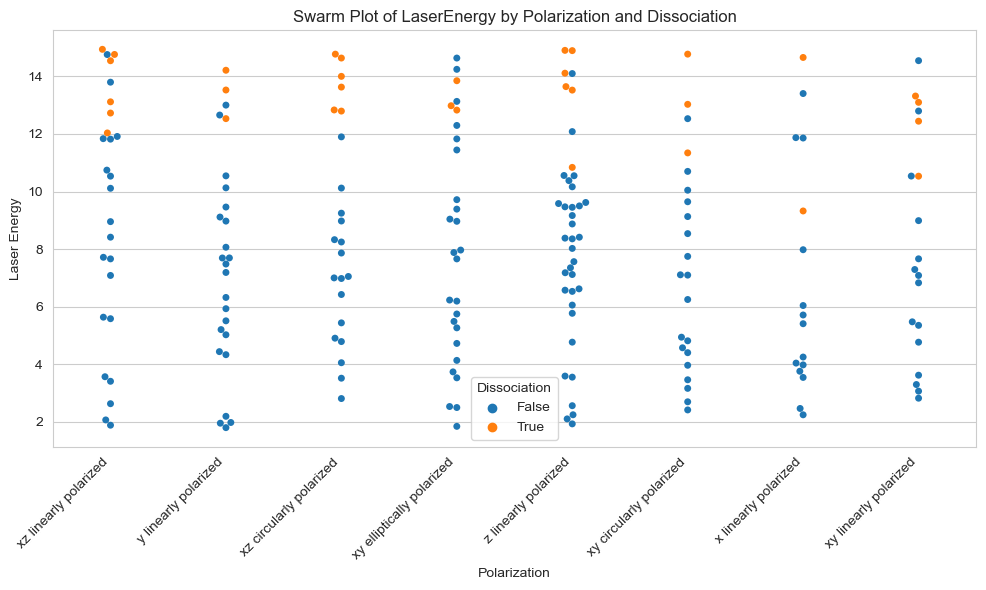

In [149]:
# Mapping dictionary
readable_polarization = {
    0: "x linearly polarized",
    1: "z linearly polarized",
    2: "y linearly polarized",
    3: "xy linearly polarized",
    4: "xz linearly polarized",
    5: "xy circularly polarized",
    6: "xz circularly polarized",
    7: "xy elliptically polarized"
}

# Create a new column 'ReadablePolarization' by mapping the 'PolarizationCategory' through the dictionary
df2['ReadablePolarization'] = df2['PolarizationCategory'].map(readable_polarization)

# Now create the swarm plot using the 'ReadablePolarization' for the x-axis labels
plt.figure(figsize=(10, 6))
sns.swarmplot(x='ReadablePolarization', y='LaserEnergy', hue="Dissociation", data=df2)

# Improve the readability of the plot
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title('Swarm Plot of LaserEnergy by Polarization and Dissociation')
plt.xlabel('Polarization')  # Rename x-axis to 'Polarization'
plt.ylabel('Laser Energy')  # Rename y-axis to 'Laser Energy'
plt.tight_layout()  # Adjust layout so everything fits without overlapping

# Display the plot
plt.show()

/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



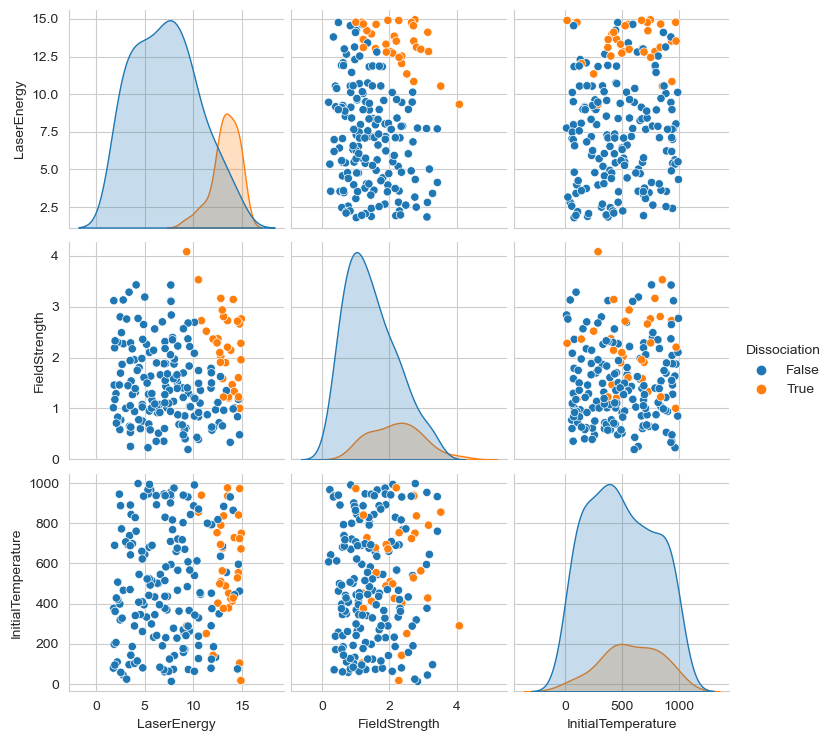

In [150]:
sns.pairplot(df[['LaserEnergy', 'FieldStrength', 'InitialTemperature', 'Dissociation']], hue="Dissociation")
plt.show()


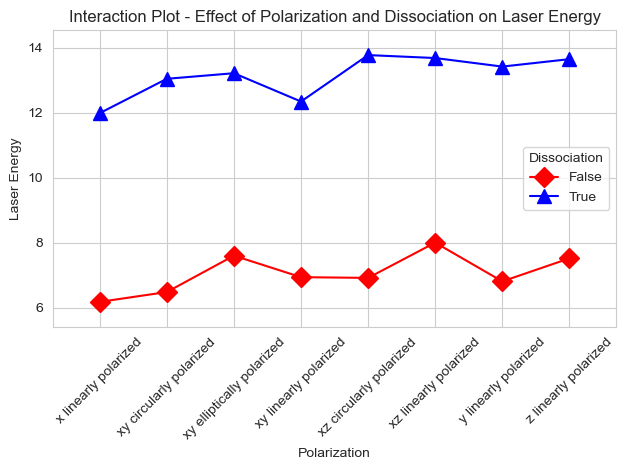

In [158]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np

# Define the mapping from polarization category numbers to readable names
readable_polarization = {
    0: "x linearly polarized",
    1: "z linearly polarized",
    2: "y linearly polarized",
    3: "xy linearly polarized",
    4: "xz linearly polarized",
    5: "xy circularly polarized",
    6: "xz circularly polarized",
    7: "xy elliptically polarized"
}

# Create a new column 'ReadablePolarization' by mapping the 'PolarizationCategory' through the dictionary
df2['ReadablePolarization'] = df2['PolarizationCategory'].map(readable_polarization)

# Now create the interaction plot using the 'ReadablePolarization' for the x-axis labels
fig = interaction_plot(x=df2['ReadablePolarization'], trace=df2['Dissociation'], response=df2['LaserEnergy'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)

# Customize the plot
plt.title('Interaction Plot - Effect of Polarization and Dissociation on Laser Energy')
plt.xlabel('Polarization')  # Rename x-axis to 'Polarization'
plt.ylabel('Laser Energy')  # Rename y-axis to 'Laser Energy'
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout so everything fits without overlapping

# Display the plot
plt.show()

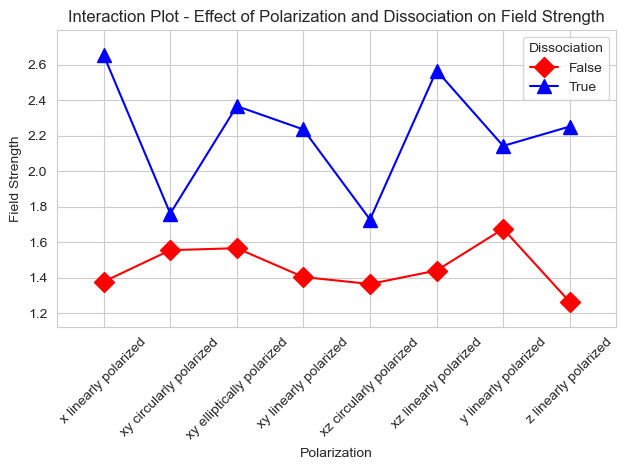

In [159]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
# Define the mapping from polarization category numbers to readable names
readable_polarization = {
    0: "x linearly polarized",
    1: "z linearly polarized",
    2: "y linearly polarized",
    3: "xy linearly polarized",
    4: "xz linearly polarized",
    5: "xy circularly polarized",
    6: "xz circularly polarized",
    7: "xy elliptically polarized"
}

# Create a new column 'ReadablePolarization' by mapping the 'PolarizationCategory' through the dictionary
df2['ReadablePolarization'] = df2['PolarizationCategory'].map(readable_polarization)

# Now create the interaction plot using the 'ReadablePolarization' for the x-axis labels
fig = interaction_plot(x=df2['ReadablePolarization'], trace=df2['Dissociation'], response=df2['FieldStrength'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)

# Customize the plot
plt.title('Interaction Plot - Effect of Polarization and Dissociation on Field Strength')
plt.xlabel('Polarization')  # Rename x-axis to 'Polarization'
plt.ylabel('Field Strength')  # Rename y-axis to 'Field Strength'
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout so everything fits without overlapping

# Display the plot
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize and train your classifier on the PCA-transformed data
clf_pca = LogisticRegression(random_state=42)
clf_pca.fit(X_train_pca, y_train)


# Create a mesh to plot in
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict classifications for each point in the mesh
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='g')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary after PCA')
plt.show()

In [726]:
X_train.columns

Index(['LaserEnergy', 'FieldStrength', 'InitialTemperature', 'Steps',
       'FinalDistance', 'PolarizationCategory'],
      dtype='object')

/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



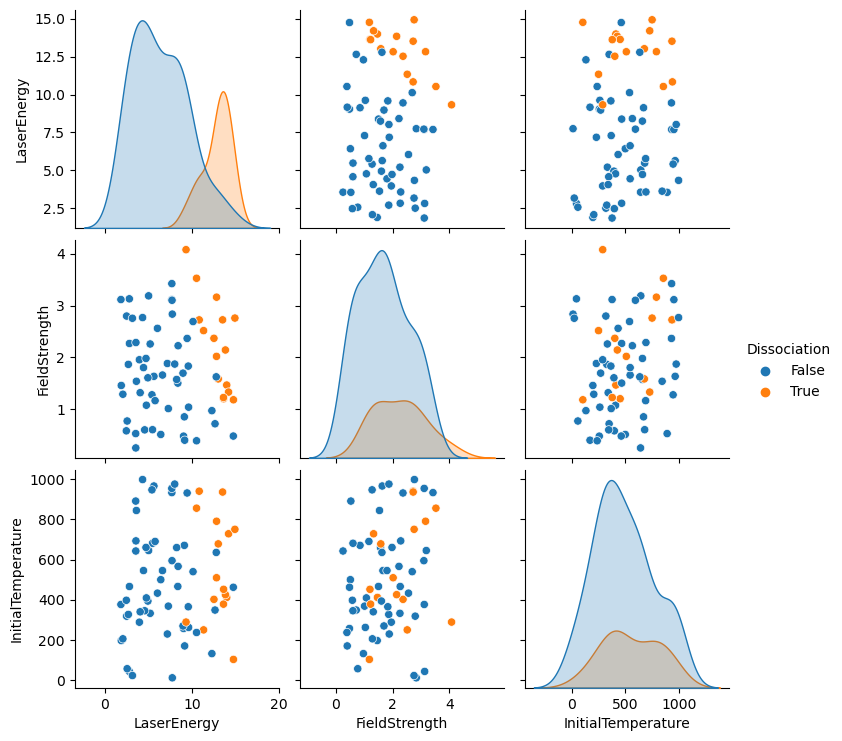

In [685]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pair plot for a subset of features
sns.pairplot(df, vars=['LaserEnergy', 'FieldStrength', 'InitialTemperature'], hue="Dissociation", diag_kind='kde')
plt.show()


In [597]:
import plotly.express as px

# Convert boolean labels to integers for coloring
df['Dissociation_int'] = df['Dissociation'].astype(int)

# Plotly 3D scatter plot
fig = px.scatter_3d(df, x='LaserEnergy', y='FieldStrength', z='InitialTemperature', color='Dissociation_int',
                    labels={'Dissociation_int': 'Dissociation'})
fig.update_layout(coloraxis_colorbar=dict(title="Dissociation"))
fig.show()


In [598]:
from sklearn.manifold import TSNE
import numpy as np

# Assuming X_train is your features DataFrame and y_train is the labels Series
X_embedded = TSNE(n_components=2, random_state=42, perplexity = 20).fit_transform(X_train)
y_train_int = y_train.astype(int)  # Convert boolean labels to integers for coloring

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train_int, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(ticks=[0, 1], label='Dissociation')
plt.title('t-SNE Visualization of the Dataset')
plt.show()


ValueError: setting an array element with a sequence.

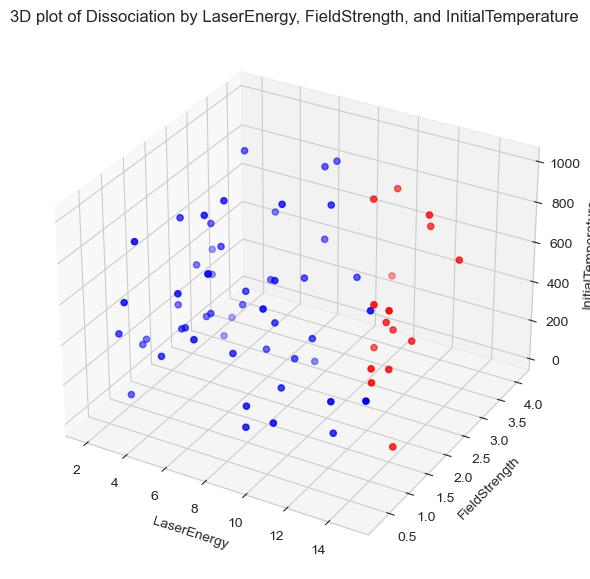

In [687]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map the Dissociation status to colors
colors = df['Dissociation'].map({True: 'red', False: 'blue'})

ax.scatter(df['LaserEnergy'], df['FieldStrength'], df['InitialTemperature'], c=colors, marker='o')
ax.set_xlabel('LaserEnergy')
ax.set_ylabel('FieldStrength')
ax.set_zlabel('InitialTemperature')
plt.title('3D plot of Dissociation by LaserEnergy, FieldStrength, and InitialTemperature')
plt.show()


/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



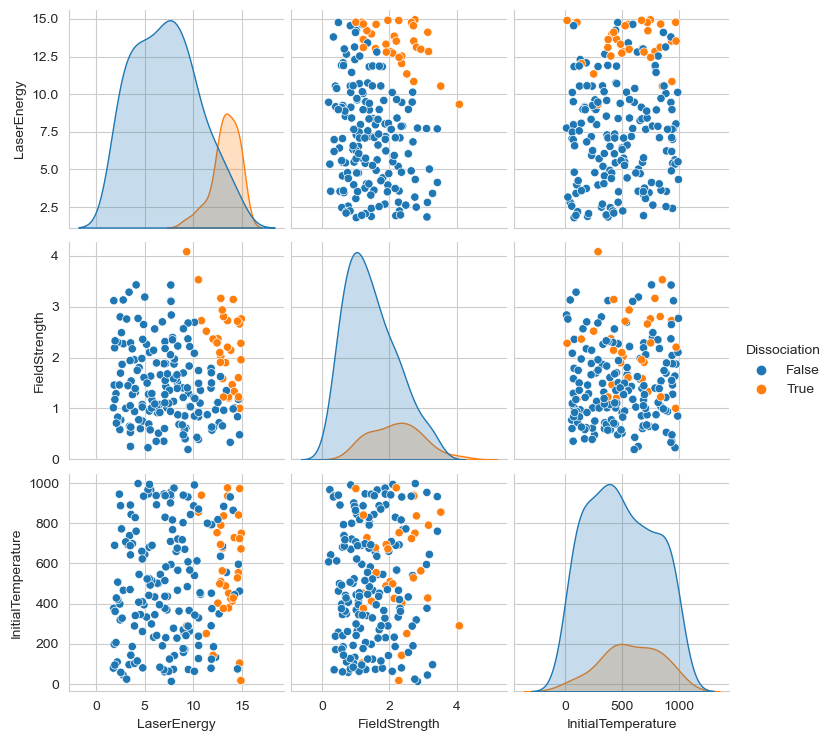

In [144]:
sns.pairplot(df[['LaserEnergy', 'FieldStrength', 'InitialTemperature', 'Dissociation']], hue="Dissociation")
plt.show()


/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



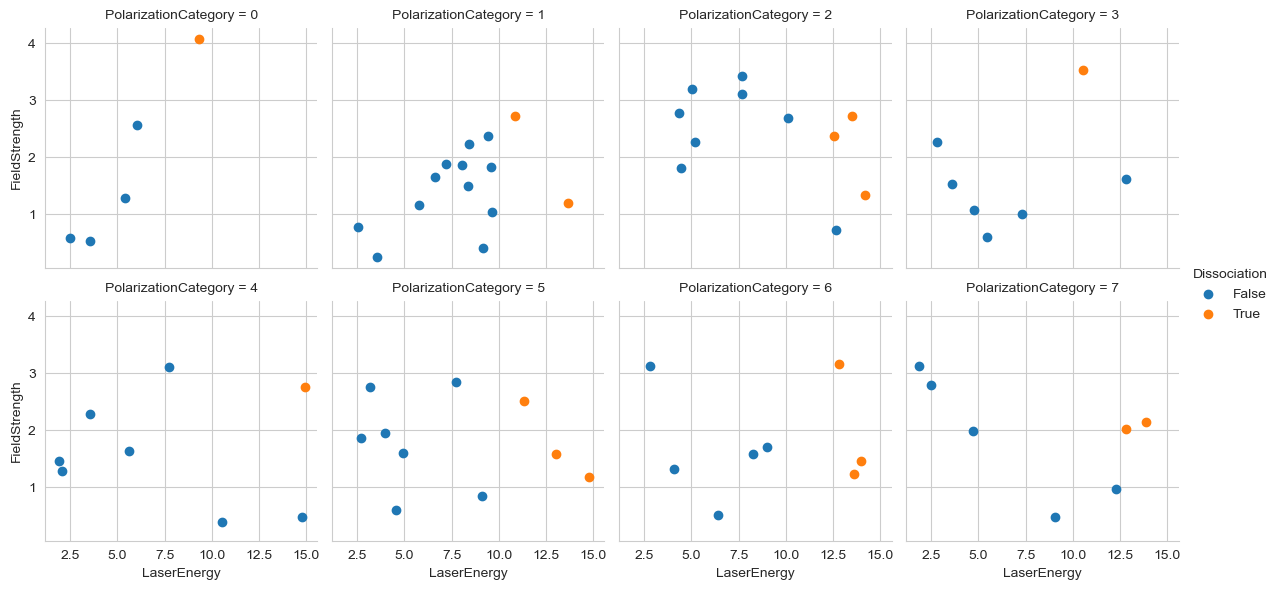

In [689]:
g = sns.FacetGrid(df, col="PolarizationCategory", hue="Dissociation", col_wrap=4, height=3)
g = g.map(plt.scatter, "LaserEnergy", "FieldStrength").add_legend()


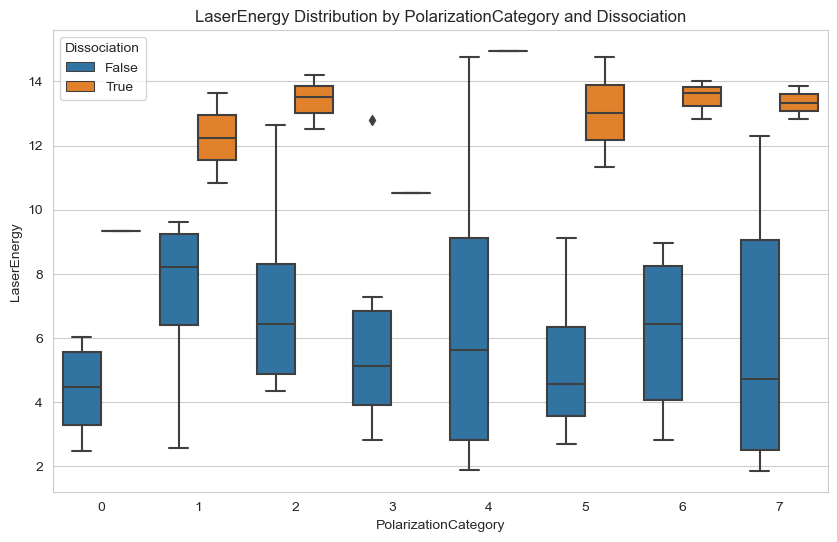

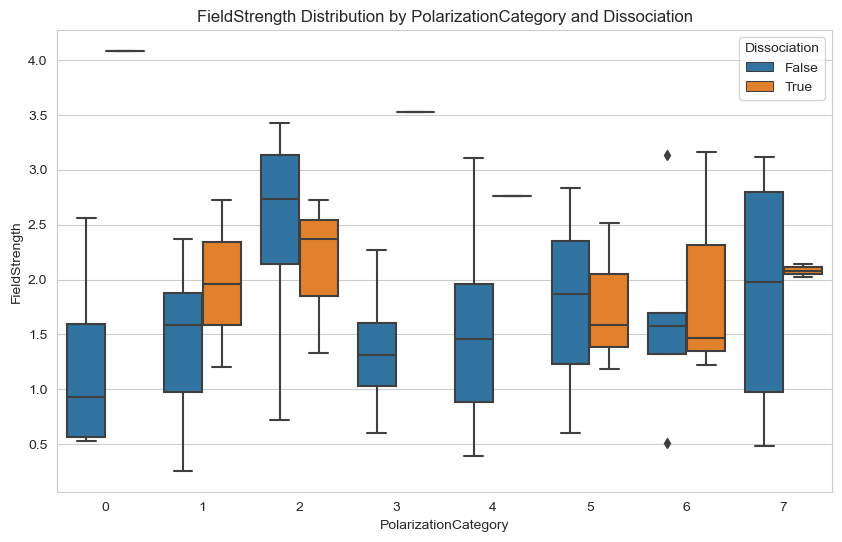

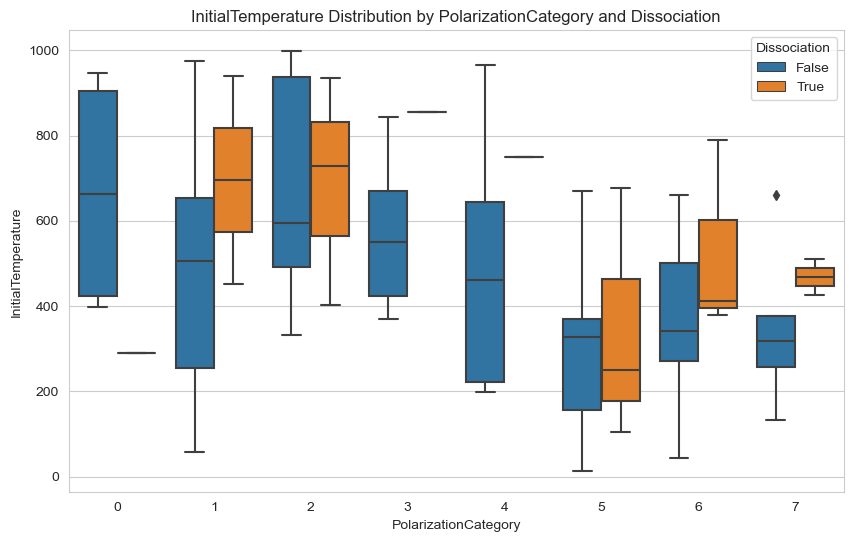

In [690]:
features = ['LaserEnergy', 'FieldStrength', 'InitialTemperature']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='PolarizationCategory', y=feature, hue="Dissociation", data=df)
    plt.title(f'{feature} Distribution by PolarizationCategory and Dissociation')
    plt.show()


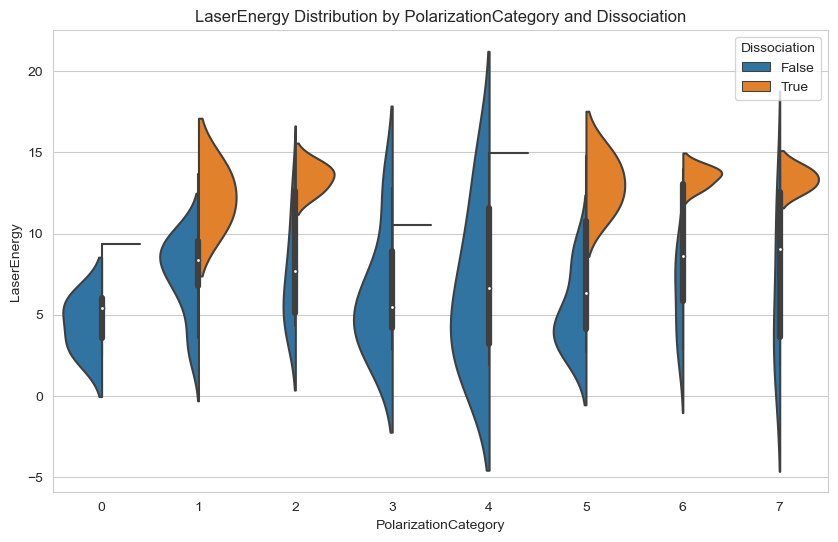

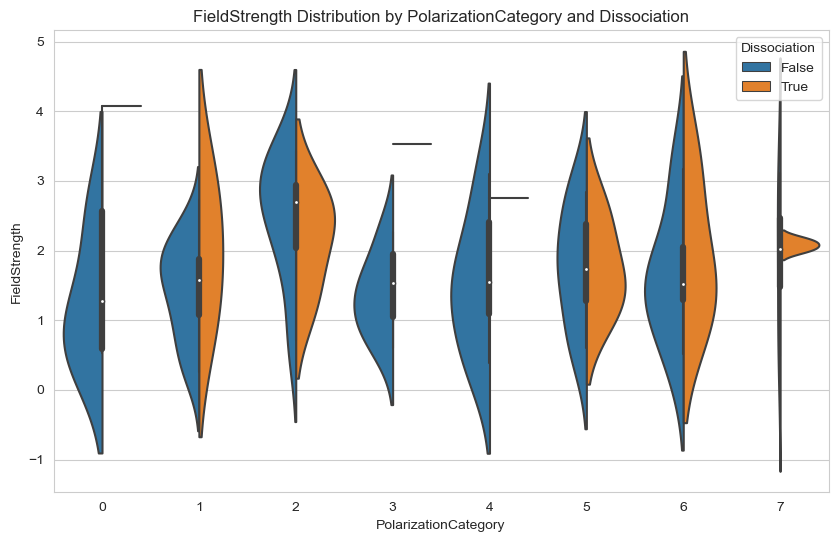

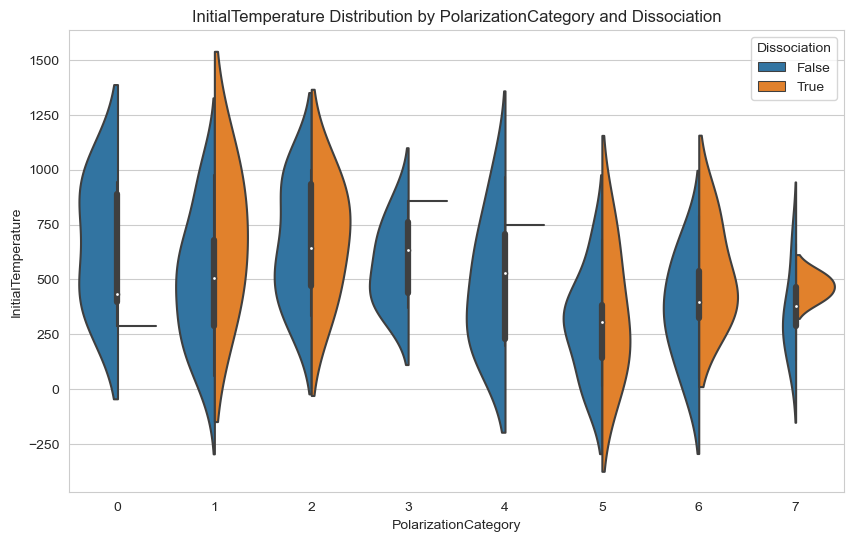

In [691]:
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='PolarizationCategory', y=feature, hue="Dissociation", data=df, split=True)
    plt.title(f'{feature} Distribution by PolarizationCategory and Dissociation')
    plt.show()


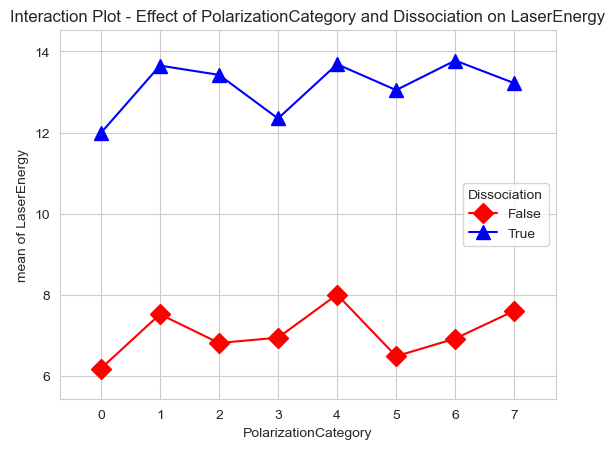

In [146]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np

fig = interaction_plot(df2['PolarizationCategory'], df2['Dissociation'], df2['LaserEnergy'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
plt.title('Interaction Plot - Effect of PolarizationCategory and Dissociation on LaserEnergy')
plt.show()


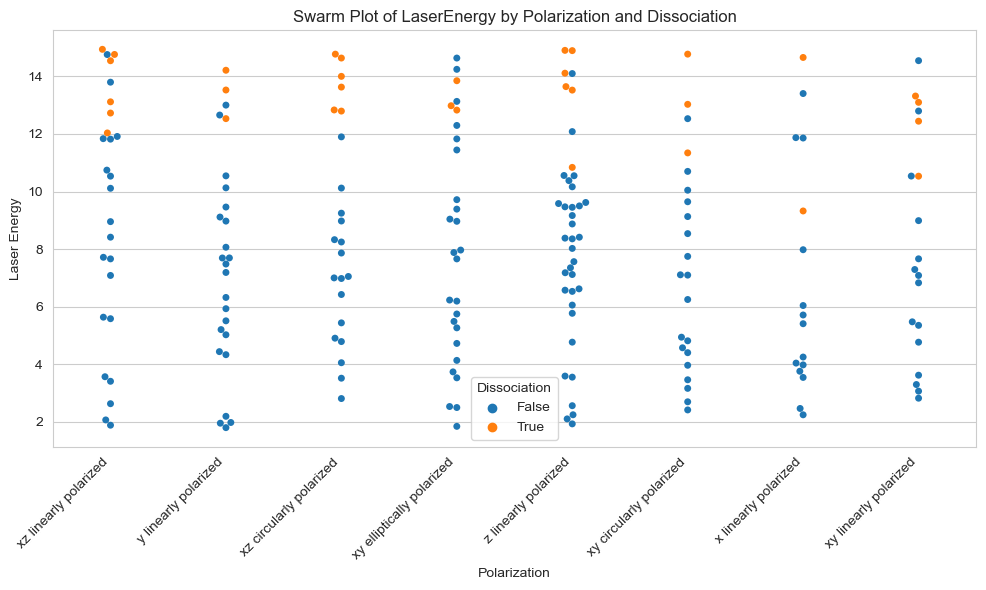

In [148]:
# Mapping dictionary
readable_polarization = {
    0: "x linearly polarized",
    1: "z linearly polarized",
    2: "y linearly polarized",
    3: "xy linearly polarized",
    4: "xz linearly polarized",
    5: "xy circularly polarized",
    6: "xz circularly polarized",
    7: "xy elliptically polarized"
}

# Create a new column 'ReadablePolarization' by mapping the 'PolarizationCategory' through the dictionary
df2['ReadablePolarization'] = df2['PolarizationCategory'].map(readable_polarization)

# Now create the swarm plot using the 'ReadablePolarization' for the x-axis labels
plt.figure(figsize=(10, 6))
sns.swarmplot(x='ReadablePolarization', y='LaserEnergy', hue="Dissociation", data=df2)

# Improve the readability of the plot
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title('Swarm Plot of LaserEnergy by Polarization and Dissociation')
plt.xlabel('Polarization')  # Rename x-axis to 'Polarization'
plt.ylabel('Laser Energy')  # Rename y-axis to 'Laser Energy'
plt.tight_layout()  # Adjust layout so everything fits without overlapping

# Display the plot
plt.show()

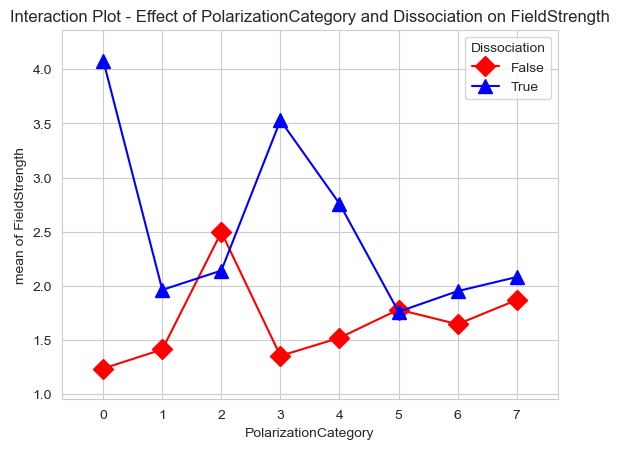

In [694]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np

fig = interaction_plot(df['PolarizationCategory'], df['Dissociation'], df['FieldStrength'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
plt.title('Interaction Plot - Effect of PolarizationCategory and Dissociation on FieldStrength')
plt.show()


/Users/ayushsharma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



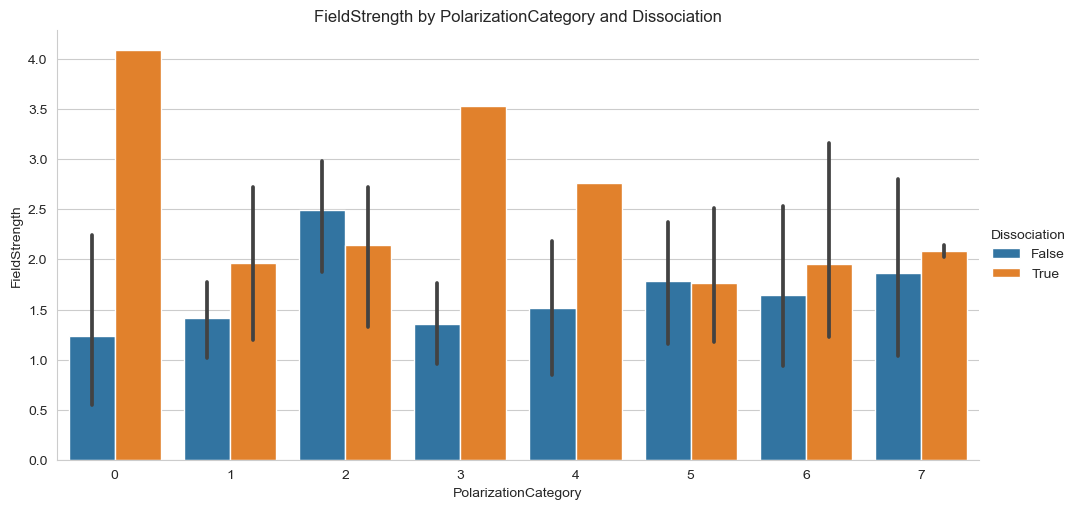

In [695]:
sns.catplot(x="PolarizationCategory", y="FieldStrength", hue="Dissociation", kind="bar", data=df, aspect=2)
plt.title('FieldStrength by PolarizationCategory and Dissociation')
plt.show()
